# Single cell fold change detection (FCD)
### 1. Overview
How single *Dictyostelium* cells react to extracellular $cAMP_{e}$ concentration can help us explainthe emergent population features. An example is population-wide oscillations is somewhat resistant to variabilities in cel density and $cAMP_{e}$ dilution/ degradation rate. This feature could be explained by the recently shown single-cell feature, which is fold change detection(FCD). Cells that displays FCD decides whether to produce a $cAMP_{i}$ spike as well as how high the spike is based on the fold change of $cAMP_{e}$ concentration (Kamino 2017). 

In this section we are going to explore different models's ability to reproduce the FCD feature of single *Dictyostelium* cells (Figure 5, below). With this notebook, you can play with different $cAMP_{e}$ priming concentrations as well as fold change, and compare the simulated responses ($cAMP_{i}$) produced by the priming concentration and sesondary concentration in different models.
![Figure 5](SC_FCD.png)
<h5><center>Figure5</center></h5>

#### Let's start by importing packages and setting up time scaling parameters

In [1]:
import numpy as np
import random
import math
import matplotlib.pyplot as plt
%matplotlib inline  
from scipy import signal
from scipy.signal import chirp, find_peaks, peak_widths
import pandas as pd
import scipy.io

from Gregor2010_agent_and_pop_FUN import  Gregor2010_agent
from Sgro2015_agent_and_pop_FUN import Sgro2015_agent
from Goldbeter1987_agent_and_pop_FUN import Goldbeter1987_agent_3var
from MaedaLoomis2004_agent_and_pop_FUN import MaedaLoomis2004_agent
from Kamino2017_agent_and_pop_FUN import Kamino2017_agent 

from NB_SC_functions import * 

Nt_Gregor = 6 
Nt_Sgro = 27
Nt_Goldbeter = 6.94
Nt_Maeda = 3.57
Nt_Kamino = 5.22

### 2. Experimental data 
#### import and plot experimental data

C:\Users\ellin\Anaconda3\lib\site-packages\pandas\util\_decorators.py:188: FutureWarning: The `sheetname` keyword is deprecated, use `sheet_name` instead
  return func(*args, **kwargs)
C:\Users\ellin\Anaconda3\lib\site-packages\matplotlib\legend.py:497: UserWarning: Unrecognized location "top center". Falling back on "best"; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center

  % (loc, '\n\t'.join(self.codes)))


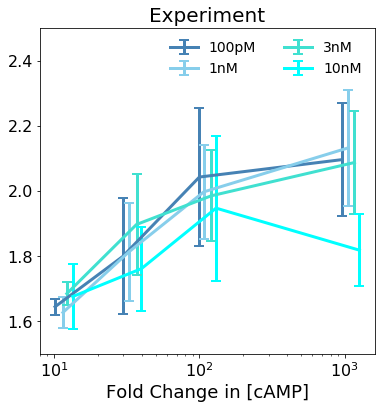

In [2]:
my_dir = r'C:/Users/ellin/Dropbox/AACP Science/Dicty model review drafts/figures/'
Kamino_FCD = pd.read_excel(my_dir+r'Kamino_FCD_exp_data.xlsx',sheetname='Sheet1')

fig3 = plt.figure(figsize=(6,6))
grid = plt.GridSpec(1,1, wspace=0.3, hspace=0.9)

ax0= fig3.add_subplot(grid[0, 0])
ax0.errorbar(Kamino_FCD["FC_100pM"], Kamino_FCD["100pM mean"], yerr=Kamino_FCD["100pM SD"], xerr=None, color='SteelBlue', linewidth=3, label='100pM', ecolor='SteelBlue', elinewidth=3,capsize=5,capthick=2)
ax0.errorbar(Kamino_FCD["FC_1nM"], Kamino_FCD["1nM mean"], yerr=Kamino_FCD["1nM SD"], xerr=None, color='SkyBlue', linewidth=3, label='1nM', ecolor='SkyBlue', elinewidth=3,capsize=5,capthick=2)
ax0.errorbar(Kamino_FCD["FC_3nM"], Kamino_FCD["3nM mean"], yerr=Kamino_FCD["3nM SD"], xerr=None, color='turquoise', linewidth=3, label='3nM', ecolor='turquoise', elinewidth=3,capsize=5,capthick=2)
ax0.errorbar(Kamino_FCD["FC_10nM"], Kamino_FCD["10nM mean"], yerr=Kamino_FCD["10nM SD"], xerr=None, color='cyan', linewidth=3, label='10nM', ecolor='cyan', elinewidth=3,capsize=5,capthick=2)
ax0.set_ylim([1.5,2.5])
# ax0.set_ylabel( 'Response Amplitude, A.U.',fontsize=tick_font_size)
ax0.set_xlabel('Fold Change in [cAMP]',fontsize=18)
ax0.set_xscale('log')
ax0.tick_params(axis='both', which='major', labelsize=16)
ax0.set_title('Experiment', color = 'k',fontdict={'fontsize': 20, 'fontweight': 'medium'})
leg = ax0.legend()
ax0.legend( frameon=False,loc='top center',ncol=2,prop={'size': 14})

### 3. Matiel 1986
#### Set up parameters (from Table II in [Matiel & Goldbeter 1986](https://www.sciencedirect.com/science/article/pii/S0006349587832757?via%3Dihub) )

In [3]:
k1 = 0.036     # per min
k2 = 0.666    # per min
L1 = 10; L2 = 0.005 
c = 10;           # 0.15 ~ 50
lamda = 0.01; theta = 0.01; e =  1 ; q = 4000; sig= 0.6
v = 12; k = 4 # k prime in the paper
ki = 1.7; kt = 0.9; kc = 5.4; h = 5
Goldbeter3AgentParam={'k1':k1,'k2':k2,'L1':L1,'L2':L2, 'c':c, 'lamda':lamda,\
            'theta':theta, 'e':e, 'q':q,'sig':sig, 'v':v, 'k':k, \
            'ki':ki,'kt':kt, 'kc':kc,'h':h}
dt=0.001; t_tot=20*Nt_Goldbeter; t=list(np.arange(0,t_tot,dt))
cAMP = 1

#### Define priming concentration array and fold change array and get simulated response
Optional: plot $cAMP_{i}$ responses of defined priming concentrations and fold changes

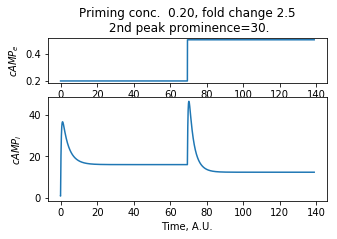

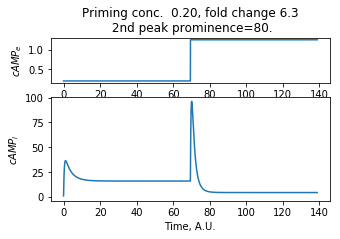

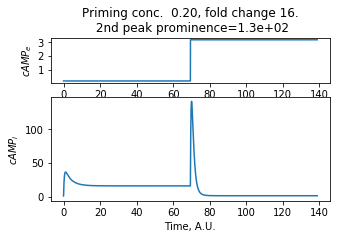

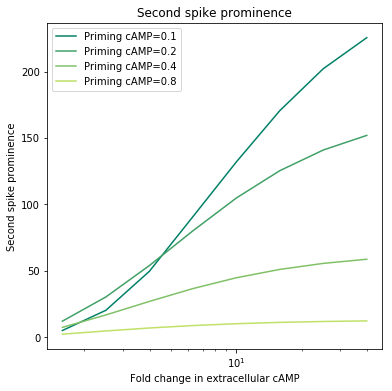

In [4]:
# priming concentration for [AMP]e 
z0First_space_Gold =np.array([0.1,0.2,0.4,0.8])
# fold change of the secondary spike compared to priming concentration # np.logspace(0.5, 0.5, num=1) 
FC_space_Gold= np.logspace(0.2, 1.6, num=8) 
# upper and lower limits of prominence in peak detection
prm_lims_Gold = [0.1,500]
# Define the end time of second peak detection  
SecondPkEndTime = 20
# define which traces to plot, 1st column defines the index of priming concentration, 
# 2nd column defines the index of fold change
single_trace_to_plot = np.array([[1,1],[1,3], [1,5]])
PkPrm_Gold = SC_FCD (z0First_space_Gold, FC_space_Gold, cAMP, Nt_Goldbeter, dt, t,  
                   prm_lims_Gold,SecondPkEndTime, single_trace_to_plot,
                   Goldbeter1986_SC, Goldbeter3AgentParam)

SC_FCD_plot(z0First_space_Gold, FC_space_Gold, PkPrm_Gold)


### 4. Maeda 2004
#### Set up parameters (from  [Maeda & Loomis 2004](https://science.sciencemag.org/content/304/5672/875/tab-article-info) )

In [5]:
k1=2.0; k2=0.9; k3=2.5; k4=1.5; k5=0.6
k6=0.8; k7=1.0; k8=1.3; k9=0.3; k10=0.8
k11=0.7; k12=4.9; k13=23; k14=4.5
MaedaAgentParam={'k1':k1,'k2':k2,'k3':k3,'k4':k4,'k5':k5,'k6':k6,\
            'k7':k7,'k8':k8,'k9':k9,'k10':k10,'k11':k11,'k12':k12,\
            'k13':k13,'k14':k14}
dt=0.001; t_tot=20*Nt_Maeda; t=list(np.arange(0,t_tot,dt))
cAMP = 1

#### Define priming concentration array and fold change array and get simulated response
Optional: plot $cAMP_{i}$ responses of defined priming concentrations and fold changes

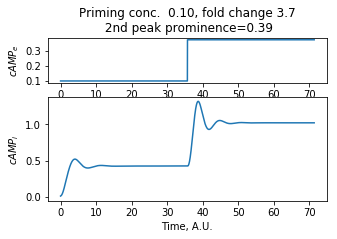

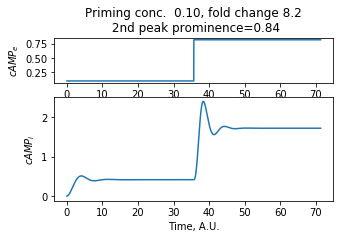

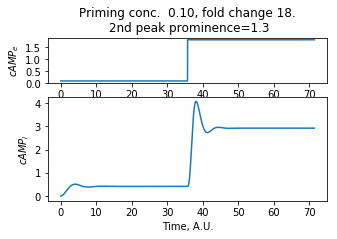

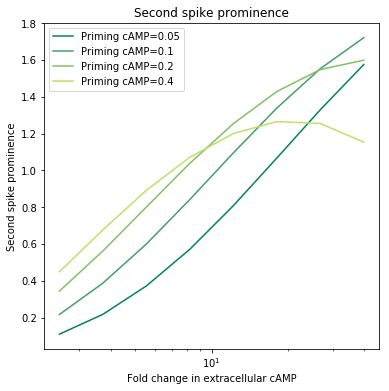

In [6]:
# priming concentration for [AMP]e 
z0First_space_Maeda = np.array([0.05, 0.1,0.2,0.4])
# fold change of the secondary spike compared to priming concentration # np.logspace(0.5, 0.5, num=1) 
FC_space_Maeda= np.logspace(0.4, 1.6, num=8) 
prm_lims_Maeda = [0,100]
# Define the end time of second peak detection  
SecondPkEndTime = 20
# define which traces to plot, 1st column defines the index of priming concentration, 
# 2nd column defines the index of fold change
single_trace_to_plot = np.array([[1,1],[1,3], [1,5]])
PkPrm_Maeda = SC_FCD (z0First_space_Maeda, FC_space_Maeda, cAMP, Nt_Maeda, dt, t,  
                   prm_lims_Maeda,SecondPkEndTime, single_trace_to_plot,
                   Maeda2004_SC, MaedaAgentParam)

SC_FCD_plot(z0First_space_Maeda, FC_space_Maeda, PkPrm_Maeda)

### 5. Sgro 2015 without noise
#### Set up parameters (from [Sgro 2015](https://www.embopress.org/doi/full/10.15252/msb.20145352) )

In [7]:
e=0.1; tauA=0.09; tauR=tauA/e; g=0.5
sigma = 0 # noise strength
SgroAgentParam={'e':e,'tauA':tauA,'tauR':tauR,'g':g,'c0':1.2,'sigma':0,'N':100,\
            'a':0.058,'alpha0':800,'alpha_pde':1000,'Kd':1e-5,'S':1e6,\
            'Nt':27,'Na':3.5,'offset_A':1.5,'flux_thrs':0}
dt=0.001 ; t_tot=20*Nt_Sgro; t=list(np.arange(0,t_tot,dt))
cAMP = 1

#### Define priming concentration array and fold change array and get simulated response
Optional: plot $cAMP_{i}$ responses of defined priming concentrations and fold changes

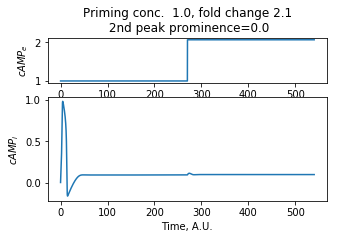

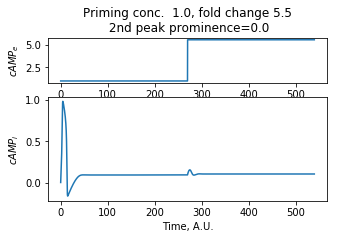

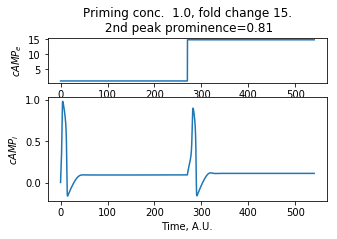

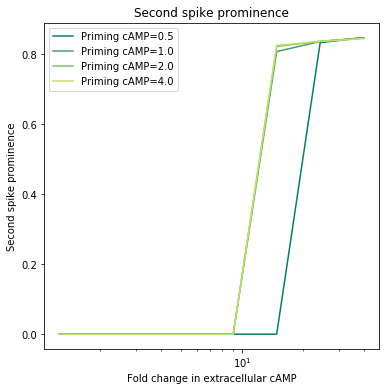

In [8]:
# priming concentration for [AMP]e 
z0First_space_Sgro = np.array([0.5,1,2,4])
# fold change of the secondary spike compared to priming concentration # np.logspace(0.5, 0.5, num=1) 
FC_space_Sgro = np.logspace(0.1, 1.6, num=8)
prm_lims_Sgro = [0.4,2]
# Define the end time of second peak detection  
SecondPkEndTime = 12.5
# define which traces to plot, 1st column defines the index of priming concentration, 
# 2nd column defines the index of fold change
single_trace_to_plot = np.array([[1,1],[1,3], [1,5]])
PkPrm_Sgro = SC_FCD (z0First_space_Sgro, FC_space_Sgro, cAMP, Nt_Sgro, dt, t,  
                   prm_lims_Sgro,SecondPkEndTime, single_trace_to_plot,
                   Sgro2015_SC, SgroAgentParam)

SC_FCD_plot(z0First_space_Sgro, FC_space_Sgro, PkPrm_Sgro)

### 6. Sgro 2015 WITH noise
#### Set up parameters (from [Sgro 2015](https://www.embopress.org/doi/full/10.15252/msb.20145352) )

In [9]:
e=0.1; tauA=0.09; tauR=tauA/e; g=0.5
sigma = 0.15 # noise strength
SgroAgentParam={'e':e,'tauA':tauA,'tauR':tauR,'g':g,'c0':1.2,'sigma':sigma,'N':100,\
            'a':0.058,'alpha0':800,'alpha_pde':1000,'Kd':1e-5,'S':1e6,\
            'Nt':27,'Na':3.5,'offset_A':1.5,'flux_thrs':0}
dt=0.001 ; t_tot=20*Nt_Sgro; t=list(np.arange(0,t_tot,dt))
cAMP = 1

#### Define priming concentration array and fold change array and get simulated response
Optional: plot $cAMP_{i}$ responses of defined priming concentrations and fold changes

The 0th priming concentration is finished


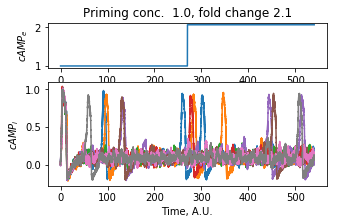

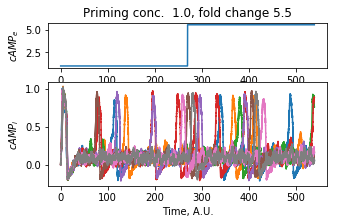

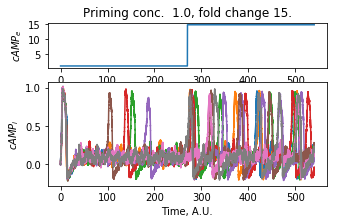

The 1th priming concentration is finished
The 2th priming concentration is finished
The 3th priming concentration is finished


In [10]:
# priming concentration for [AMP]e 
z0First_space_Sgro = np.array([0.5,1,2,4])
# fold change of the secondary spike compared to priming concentration # np.logspace(0.5, 0.5, num=1) 
FC_space_Sgro = np.logspace(0.1, 1.6, num=8)
prm_lims_Sgro = [0.4,2]
# Define the end time of second peak detection  
SecondPkEndTime = 12.5
num_of_runs = 8
# define which traces to plot, 1st column defines the index of priming concentration, 
# 2nd column defines the index of fold change
single_trace_to_plot = np.array([[1,1],[1,3],[1,5]])
PkPrm_noise_Sgro, PkPrm_mean_noise_Sgro, PkPrm_se_noise =SC_FCD_Noise(z0First_space_Sgro, FC_space_Sgro, 
                                                                      num_of_runs,cAMP, Nt_Sgro, dt, t,
                                                                      prm_lims_Sgro,SecondPkEndTime, single_trace_to_plot,
                                                                      Sgro2015_SC, SgroAgentParam)


#### Plot results
Mean second peak pominence among all the simulation runs


C:\Users\ellin\Anaconda3\lib\site-packages\matplotlib\legend.py:497: UserWarning: Unrecognized location "bottom center". Falling back on "best"; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center

  % (loc, '\n\t'.join(self.codes)))


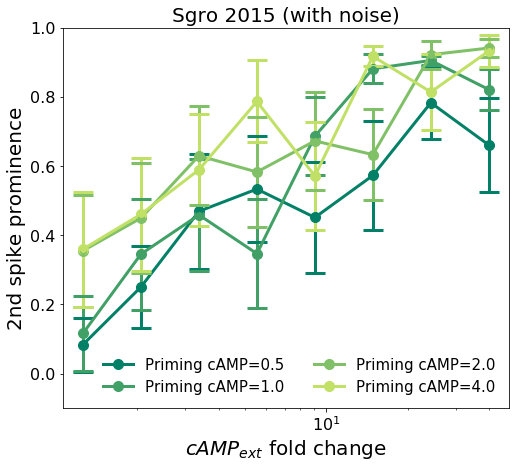

In [11]:
colors = plt.cm.summer(np.linspace(0,1,len(z0First_space_Sgro)+1))
fig3 = plt.figure(figsize=(8, 7))
grid = plt.GridSpec(1, 1, wspace=0.1, hspace=0.35)
ax3= fig3.add_subplot(grid[0, 0])
for i in range(len(z0First_space_Sgro)):
    ax3.plot(FC_space_Sgro, PkPrm_mean_noise_Sgro[i,:],'o-', color = colors[i], lw = 3, ms = 10,  label='Priming cAMP='+str(z0First_space_Sgro[i]))
    ax3.errorbar(FC_space_Sgro, PkPrm_mean_noise_Sgro[i,:], yerr=PkPrm_se_noise[i,:],
                 fmt = 'o', color=colors[i], ecolor= colors[i], elinewidth=3, capsize=10, capthick=3)
ax3.set_ylim([-0.1,1])
ax3.set_ylabel( '2nd spike prominence',fontsize=20)
ax3.set_xlabel(r'$cAMP_{ext}$'+' fold change',fontsize=20)
ax3.set_xscale('log')
ax3.tick_params(axis='both', which='major', labelsize=16)
ax3.set_title('Sgro 2015 (with noise)', fontdict={'fontsize': 20, 'fontweight': 'medium'})
leg = ax3.legend();
ax3.legend( frameon=False,loc='bottom center',ncol=2,prop={'size': 15})

## Or with SC_FCD_Noise_plot function imported 
# SC_FCD_Noise_plot(z0First_space_Sgro, FC_space_Sgro, 
                  # PkPrm_mean_noise_Sgro,PkPrm_se_noise)


### 7. Kamino 2017
#### Set up parameters (from [Kamino 2017](https://www.pnas.org/content/114/21/E4149) )

In [12]:
tau=1.5; n=2; K=4; kt=2; delta=0.01
gamma=3 # cAMPe dilution/degradation rate 
rho= 0.01 # population density, doesn't matter for single cells
KaminoAgentParam={'tau':tau,'n':n,'K':K,'kt':kt,'delta':delta,\
               'gamma':gamma,'rho':rho}
dt=0.001; t_tot=20*Nt_Kamino; t=list(np.arange(0,t_tot,dt))
cAMP = 1

#### Define priming concentration array and fold change array and get simulated response
Optional: plot $cAMP_{i}$ responses of defined priming concentrations and fold changes

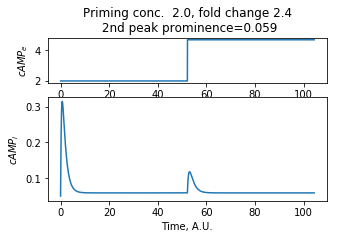

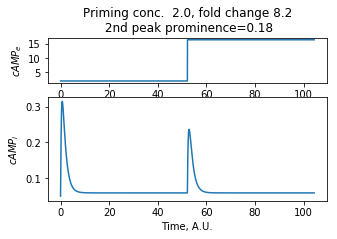

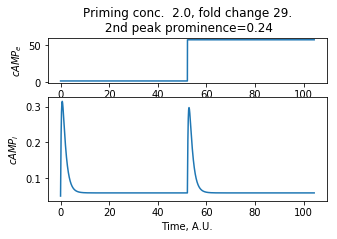

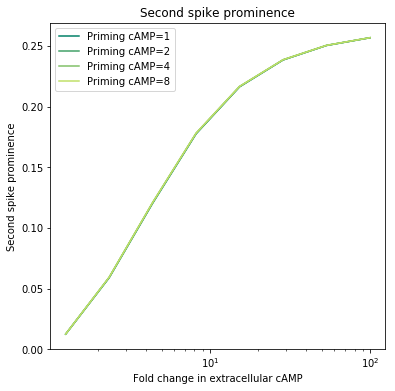

In [13]:
# priming concentration for [AMP]e 
z0First_space_Kamino = np.array([1,2,4,8]) 
# fold change of the secondary spike compared to priming concentration # np.logspace(0.5, 0.5, num=1) 
FC_space_Kamino= np.logspace(0.1, 2, num=8) 
prm_lims_Kamino = [0,10]
# Define the end time of second peak detection  
SecondPkEndTime = 20
# define which traces to plot, 1st column defines the index of priming concentration, 
# 2nd column defines the index of fold change
single_trace_to_plot = np.array([[1,1],[1,3], [1,5]])
PkPrm_Kamino = SC_FCD (z0First_space_Kamino, FC_space_Kamino, cAMP, Nt_Kamino, dt, t,  
                   prm_lims_Kamino,SecondPkEndTime,single_trace_to_plot,
                   Kamino2017_SC, KaminoAgentParam)

SC_FCD_plot(z0First_space_Kamino, FC_space_Kamino, PkPrm_Kamino)
